# Using R packages for DID estimators in Python

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from linearmodels.panel import PanelOLS

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import IntVector, Formula
import rpy2.robjects.packages as rpackages
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind = 1)

<rpy2.rinterface_lib.sexp.NULLType object at 0x00000197CE616FC0> [RTYPES.NILSXP]

### Import R packages

In [3]:
%%capture

# Bacon Decomposition
utils.install_packages("bacondecomp")
bacondecomp = rpackages.importr('bacondecomp')

# Brantly Callaway, Pedro H.C. Sant’Anna (2020) estimator
utils.install_packages("did")
did = rpackages.importr('did')

# Clément de Chaisemartin, Xavier D’Haultfoeuille (2020)
utils.install_packages("DIDmultiplegt")
DIDmultiplegt = rpackages.importr('DIDmultiplegt')

# Pedro H.C. Sant’Anna , Jun Zhao (2020).
utils.install_packages("DRDID")
DRDID = rpackages.importr('DRDID')

# Liyang Sun, Sarah Abraham (2020)
utils.install_packages("fixest")
fixest = rpackages.importr('fixest')

# Kirill Borusyak, Xavier Jaravel, Jann Spiess (2021)
utils.install_packages("didimputation")
didimputation = rpackages.importr('didimputation')

# Gardner (2021)
utils.install_packages("did2s")
did2s = rpackages.importr('did2s')

# Broom package for working with fixest models
utils.install_packages("broom")
broom = rpackages.importr('broom')

### Example using Baker dataset

In [37]:
# Import data
baker = pd.read_csv("baker.csv")

# Set groups that are never-treated to have a value of 0 
# This is easier for conversion to an R/rpy2 DataFrame
# Since we do not have any never-treated units for the Baker df, we can skip that step.

# Convert the pandas df to an R/rpy2 DataFrame for use with the R packages
with localconverter(ro.default_converter + pandas2ri.converter):
      rbaker = ro.conversion.py2rpy(baker)

In [39]:
baker = baker.set_index(['individual', 'time'])
baker

state     firms  year   n    id  group  treat_date  treat  \
individual time                                                              
1          1980      1  0.000344  1980   1     1      1        1986      0   
           1981      1  0.000344  1981   2     1      1        1986      0   
           1982      1  0.000344  1982   3     1      1        1986      0   
           1983      1  0.000344  1983   4     1      1        1986      0   
           1984      1  0.000344  1984   5     1      1        1986      0   
...                ...       ...   ...  ..   ...    ...         ...    ...   
1000       2005     40  4.954122  2005  26  1000      4        2004      1   
           2006     40  4.954122  2006  27  1000      4        2004      1   
           2007     40  4.954122  2007  28  1000      4        2004      1   
           2008     40  4.954122  2008  29  1000      4        2004      1   
           2009     40  4.954122  2009  30  1000      4        2004      1   

                        te         e         y2          y  
individual time                                             
1          1980  10.030478  0.148687   1.149030   1.149030  
           1981   9.976846 -0.238707   1.761637   1.761637  
           1982   9.987340  0.188533   3.188877   3.188877  
           1983  10.001581  0.181264   4.181607   4.181607  
           1984  10.021217 -0.488355   4.511988   4.511988  
...                    ...       ...        ...        ...  
1000       2005   4.014460 -0.037891  34.930690  38.945150  
           2006   4.017321  0.303873  36.275316  44.309958  
           2007   4.061008  0.372471  37.387601  49.570625  
           2008   3.978057  0.536419  38.468598  54.380825  
           2009   3.916656 -0.000210  38.870568  58.453847  

[30000 rows x 12 columns]

In [7]:
# Use the did2s R package to estimate TWFE, 
# Gardner (2021), 
# Callaway and Sant'Anna (2020),
# Sun and Abraham (2020)
# Borusyak, Jaravel, Spiess (2021)
# Roth and Sant'Anna (2021)
# This R package is helpful when you want to estimate a bunch of estimators at once and contrast them.
# However, while we will focus on using individual commands for each estimators, in case this is helpful, 
# # The command has the following syntax, as defined for the Castle dataset.
# Example code:
# modelsr = did2s.event_study(data = rdata,
#                  yname = 'l_homicide',
#                  gname = 'effyear',
#                  idname = 'sid',
#                  tname = 'year')
# Convert table containing estimates to a pandas df
# with localconverter(ro.default_converter + pandas2ri.converter):
#       models = ro.conversion.rpy2py(modelsr)

## Code for estimating models in Python

The following sub-sections gives sample code you can adapt to estimate models using the packages listed above.

### TWFE 

In [44]:
baker['time_til'] = baker['year'] - baker['treat_date']
baker['cons'] = 1
baker = pd.concat([baker, pd.get_dummies(baker['time_til'], prefix = "dd")], axis = 1)
dd = [dd for dd in baker.columns if dd.startswith("dd_")]
leads = {'dd_-1'}
ind_cols = [ind for ind in dd if ind not in leads]

C:\Users\sajidmu2\Anaconda3\lib\site-packages\linearmodels\panel\model.py:1831: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

dd_18, dd_19, dd_20, dd_21, dd_22, dd_23

  warnings.warn(


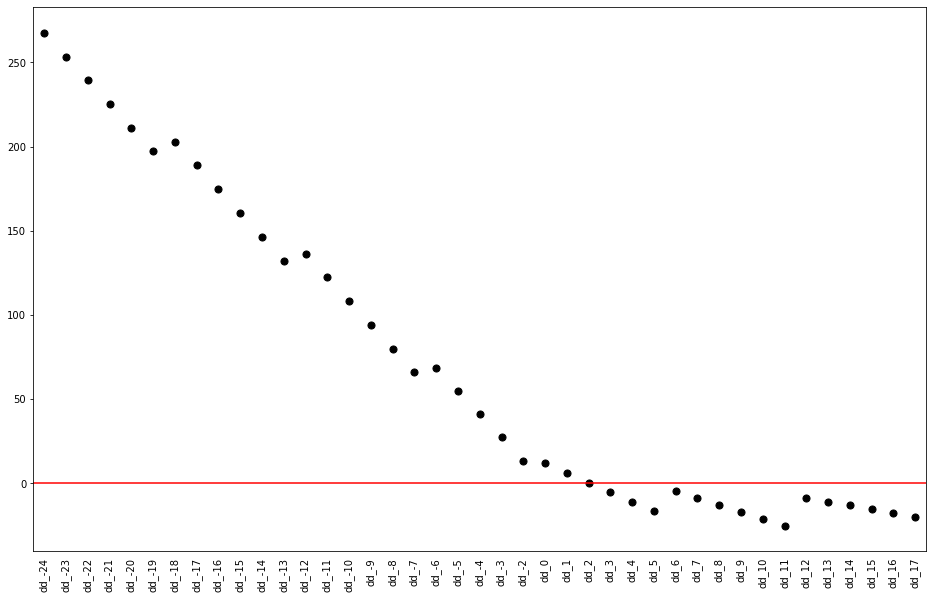

In [60]:
twfe = PanelOLS(baker.y, baker[['cons'] + ind_cols],  
                         entity_effects = True, time_effects = True,
                         check_rank = True, drop_absorbed = True).fit(cov_type = 'robust')

het_err_series = twfe.params - twfe.conf_int()['lower']
het_coef_df = pd.DataFrame({'coef': twfe.params.values[1:48],
                        'err': het_err_series.values[1:48],
                        'varname': het_err_series.index.values[1:48]
                       })

fig, ax = plt.subplots(figsize = (16, 10))
het_coef_df.plot(x = 'varname', y = 'coef', kind = 'bar', 
             ax = ax, color = 'none', 
             yerr = 'err', legend = False)
ax.set_ylabel('')
ax.set_xlabel('')
ax.axhline(y = 0, color= 'r', linestyle='-')
ax.scatter(x = np.arange(het_coef_df.shape[0]), 
           marker = 'o', s = 10, 
           y = het_coef_df['coef'], color = 'black')
ax.xaxis.set_ticks_position('none')

### Callaway and Sant'Anna (2020) - did package

In [10]:
# Estimate model, using the data converted to an R/rpy2 DataFrame

get_att_gt = did.att_gt(data = rbaker,
          yname = 'y',
          tname = 'time',
          idname = 'individual',
          gname = 'treat_date', 
          control_group = 'notyettreated')

# Aggregate results and extract for converting to a Pandas df
# You can toggle the aggregation type for whatever you want
csdid_results_r = did.tidy_AGGTEobj(did.aggte(get_att_gt, type = "dynamic"))

# The results table is an R/rpy2 dataframe. Convert this to a Pandas df
with localconverter(ro.default_converter + pandas2ri.converter):
    csdid_results = ro.conversion.rpy2py(csdid_results_r)

# Print table
csdid_results

,type,term,event.time,estimate,std.error,conf.low,conf.high,point.conf.low,point.conf.high
1,dynamic,ATT(-17),-17.0,-0.017531,0.027248,-0.101502,0.066439,-0.070937,0.035874
2,dynamic,ATT(-16),-16.0,-0.009897,0.026398,-0.091246,0.071452,-0.061635,0.041842
3,dynamic,ATT(-15),-15.0,0.033861,0.025256,-0.043969,0.111691,-0.015639,0.083361
4,dynamic,ATT(-14),-14.0,-0.008687,0.026462,-0.090234,0.072860,-0.060551,0.043177
5,dynamic,ATT(-13),-13.0,0.010769,0.025868,-0.068949,0.090486,-0.039932,0.061469
6,dynamic,ATT(-12),-12.0,-0.024517,0.024753,-0.100798,0.051764,-0.073032,0.023998
7,dynamic,ATT(-11),-11.0,-0.002178,0.020089,-0.064086,0.059730,-0.041552,0.037196
8,dynamic,ATT(-10),-10.0,0.024891,0.018604,-0.032442,0.082223,-0.011573,0.061354
9,dynamic,ATT(-9),-9.0,-0.016160,0.018425,-0.072940,0.040619,-0.052272,0.019952
10,dynamic,ATT(-8),-8.0,0.017224,0.019280,-0.042192,0.076639,-0.020565,0.055012


### Sun and Abraham (2020 )- uses sunab in the fixest R package

In [63]:
# Estimate model, using your dataset converted to an R/rpy2 DataFrame

sunab_mod = fixest.feols(fml = Formula("y ~ sunab(treat_date, time) | individual + time"), 
             subset = Formula('~year < 2004'),
             data = rbaker)

# Get results table 
sunab_resultsr = broom.tidy_fixest(sunab_mod)

# The results table is an R/rpy2 dataframe. Convert this to a Pandas df
with localconverter(ro.default_converter + pandas2ri.converter):
    sunab_results = ro.conversion.rpy2py(sunab_resultsr)

# Print table
sunab_results

,term,estimate,std.error,statistic,p.value
1,time::-18,0.035915,0.032784,1.095515,0.273555
2,time::-17,0.018963,0.031815,0.596020,0.551297
3,time::-16,0.014402,0.031991,0.450207,0.652659
4,time::-15,0.046738,0.031558,1.481032,0.138913
5,time::-14,0.037620,0.032466,1.158753,0.246834
6,time::-13,0.043390,0.031413,1.381278,0.167502
7,time::-12,-0.010092,0.022505,-0.448418,0.653949
8,time::-11,-0.019476,0.023937,-0.813638,0.416046
9,time::-10,0.010229,0.022202,0.460713,0.645105
10,time::-9,0.002593,0.022995,0.112761,0.910243


Text(0.5, 0.98, 'DID Estimators - Baker data')

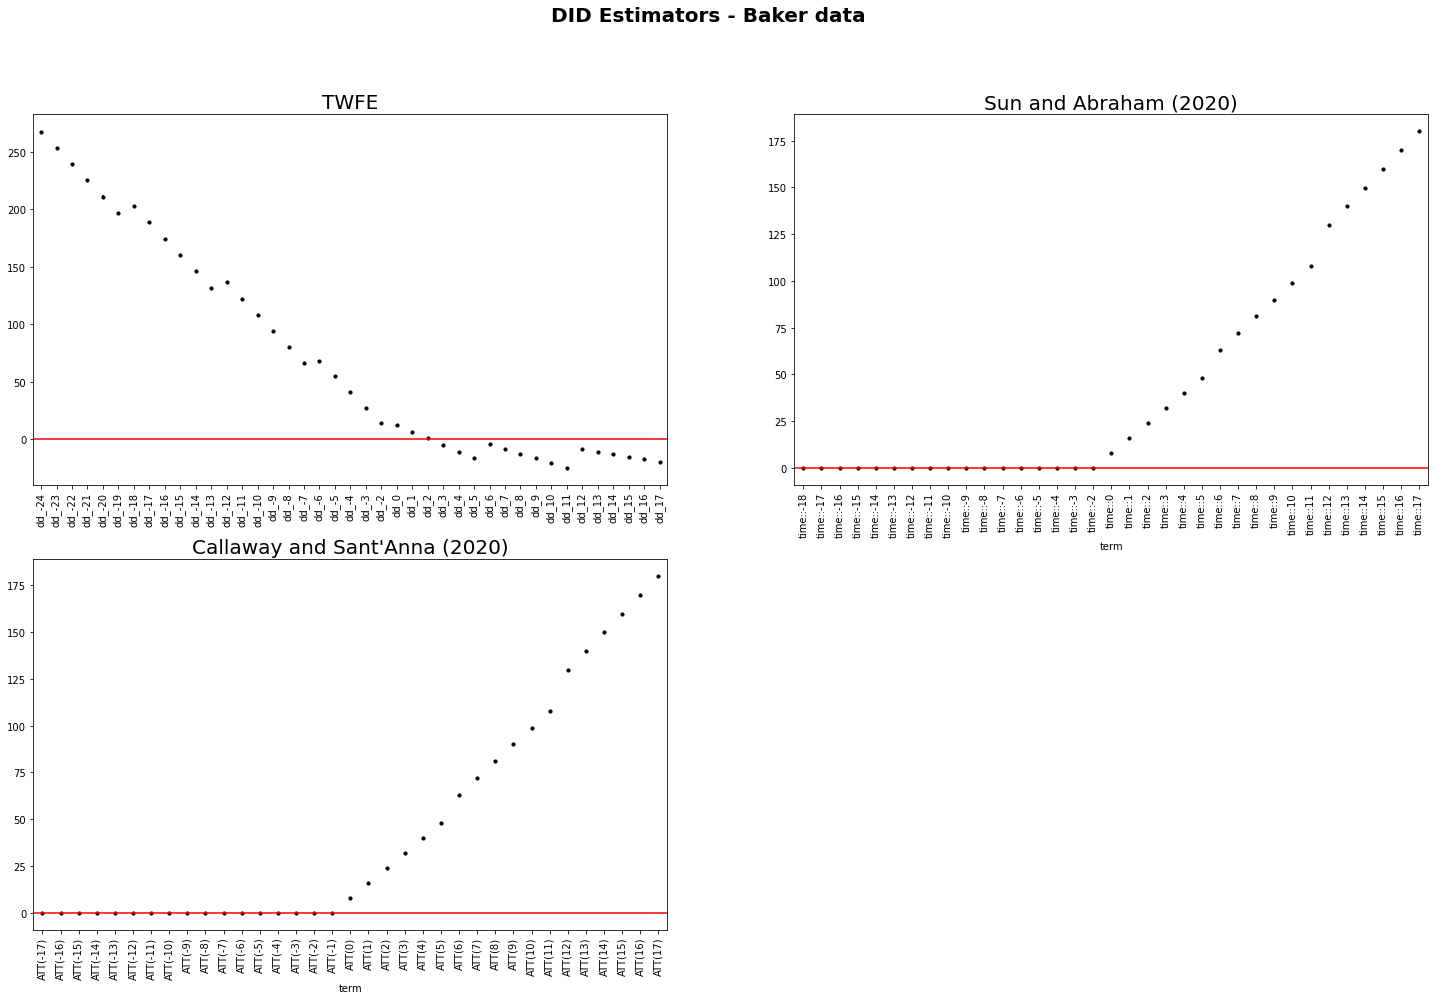

In [66]:
# Create a plot for the estimators that are suitable for our data/model

fig = plt.figure(figsize = (25, 15))

ax1 = fig.add_subplot(2, 2, 1)
het_coef_df.plot(x = 'varname', y = 'coef', kind = 'bar', 
             ax = ax1, color = 'none', 
             yerr = 'err', legend = False)
ax1.set_ylabel('')
ax1.set_xlabel('')
ax1.axhline(y = 0, color= 'r', linestyle='-')
ax1.scatter(x = np.arange(het_coef_df.shape[0]), 
           marker = 'o', s = 10, 
           y = het_coef_df['coef'], color = 'black')
ax1.set_title('TWFE', size = 20)


ax2 = fig.add_subplot(2, 2, 2)
sunab_results.plot(x = 'term', y = 'estimate', kind = 'bar', 
             ax = ax2, color = 'none', 
             yerr ='std.error', legend = False)
ax2.axhline(y = 0, color='r', linestyle='-')
ax2.scatter(x = np.arange(sunab_results.shape[0]), 
           marker = 'o', s = 10, 
           y = sunab_results['estimate'], color = 'black')
ax2.set_title('Sun and Abraham (2020)', size = 20)

ax3 = fig.add_subplot(2, 2, 3)
csdid_results.plot(x = 'term', y = 'estimate', kind = 'bar', 
             ax = ax3, color = 'none', 
             yerr ='std.error', legend = False)
ax3.axhline(y = 0, color='r', linestyle='-')
ax3.scatter(x = np.arange(csdid_results.shape[0]), 
           marker = 'o', s = 10, 
           y = csdid_results['estimate'], color = 'black')
ax3.set_title("Callaway and Sant'Anna (2020)", size = 20)


fig.suptitle("DID Estimators - Baker data", fontweight = 'bold', size = 20)